# The Incidence of Downward Mobility: Evidence from Chicago 

#### Code Author: Yizhou Zhang, Ph.D. candidate in Agricultural & Consumer Economics, Univ of Illinois at Urbana-Champaign

__Abstract__: Gentrification is the socio-economic upgrade experienced by less advantaged neighborhoods. Previous research suggests that  gentrification is associated with the downward movement of long-term , incumbent residents in the gentrifying neighborhoods. This means that if a household moved out from gentrifying neighborhoods, it tends to move to communities with lower socio-economic status than the origin neighborhood with lower median family income and lower average housing values. This paper further investigates if such gentrification-related downward movement had happened in Chicago between 2010-2015, and if gentrification has a greater incidence on renters than on homeowners. I aim to answer the following empirical questions: 

1. Are migrants from gentrifying neighborhoods more likely to experience downward mobility than their counterparts from non-gentrifying neighborhoods? 

2. Regardless of a neighborhood’s gentrification status, are renter migrants in general more likely to move to lower-income neighborhoods than owner migrants?

3. If the answer to question 2) is yes, is the owner-renter downward incidence gap greater in gentrifying neighborhoods than in non-gentrifying neighborhoods?

4. Do the outcomes differ by the intensity of gentrification of a neighborhood?   

In [1]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer
from IPython.core.display import display, HTML
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

## Data Preparation and Description

Use the American Community Survey (ACS) data between 2010-2016 to identify which census tracts gentrified between 2010-2015. The data is already downloaded. 

In [2]:
ACS1016 =  pd.read_csv("C:/Users/Max/Google Drive/My Research/Chicago Crime-Migration/data/ACS1016.csv")

# Create a new column named "MergeID" such that the table can be joined. THe MergeID is a concatination of "Year" and "GEOID"
ACS1016['MergeID'] =  ACS1016["Year"].apply(int).apply(str) +  ACS1016["GEOID"].apply(int).apply(str)

# drop the first column that is redundant
ACS1016 = ACS1016.drop(ACS1016.columns[0], 1)

In [3]:
#A preview of the data
ACS1016[:5]

,GEOID,under24,A2549,A5061,A62more,TotPop,MHHI,EDU,P_Own,pct_Built20y,MHV,MGR,Less10k,I10k_20k,more20k,TotRsp,Year,MergeID
0,17001000100,0.261459,0.327954,0.148268,0.262320,4647,40114.0,0.178179,0.864256,0.883983,96900.0,587.0,0.060122,0.101926,0.837952,2129,2010,201017001000100
1,17001000201,0.334850,0.299818,0.181074,0.184258,2198,41356.0,0.109190,0.800712,0.870700,79800.0,657.0,0.087782,0.098458,0.813760,843,2010,201017001000201
2,17001000202,0.503276,0.261778,0.138222,0.096724,3205,44076.0,0.130421,0.775216,0.974063,85100.0,624.0,0.097983,0.060519,0.841499,1041,2010,201017001000202
3,17001000400,0.328177,0.261878,0.149613,0.260331,4525,24230.0,0.057017,0.547820,0.856864,52800.0,555.0,0.111906,0.303839,0.584255,1537,2010,201017001000400
4,17001000500,0.364100,0.313703,0.159117,0.163080,1766,31583.0,0.107022,0.614966,0.952381,67200.0,580.0,0.134694,0.164626,0.700680,735,2010,201017001000500


Explaining the data variables:
-  __"GEOID"__ is the FIPSCODE of a census tract that could be used as ID.
-  __"under24"__ to __"A62more"__ are the percentages of residents that are in a certain age category.
-  __"TotPop"__ is total population in the tract in a given year. 
-  __"MHHI"__ is the median household income of a tract,
-  __"EDU"__ is the % of college-educated residents,
-  __"P_Own"__ is the % of owners,
-  __"pct_Built20y"__ is the percentage of housing stocks tha are at least 20 years old.
-  __"MHV"__ is median housing value in a tract ,
-  __"MGR"__ is median gross rent in a tract.
-  __"Year"__ is the year of observation. 

now extract all observations (census tracts) from the year 2010 and year 2010. Then join the two tables to measure the neighborhood changes between 2010-2015 in key parameters. 

In [4]:
#Extract the year 2010
ACS2010 = ACS1016[ACS1016.Year == 2010]
ACS2010 = ACS2010.rename(columns={'MHHI':'MHHI_10', 'EDU':'EDU_10','pct_Built20y':'pct_Built20y_10','MHV':'MHV_10','MGR':'MGR_10'})
ACS2010 = ACS2010[['GEOID', 'MHHI_10', 'EDU_10','pct_Built20y_10','MHV_10','MGR_10']]


# Extract the year 2015
ACS2015 = ACS1016[ACS1016.Year == 2015]
ACS2015 = ACS2015.rename(columns={'MHHI':'MHHI_15', 'EDU':'EDU_15','pct_Built20y':'pct_Built20y_15',
                                  'MHV':'MHV_15','MGR':'MGR_15'})
ACS2015 = ACS2015[['GEOID', 'MHHI_15', 'EDU_15','pct_Built20y_15','MHV_15','MGR_15']]

<br>


### Merge two tables _ACS2010_ and _ACS2015_ to calculate characteristics changes

In [5]:
Gent1015 =  pd.merge(ACS2010, ACS2015, how='inner', on = "GEOID")

Gent1015 = Gent1015.dropna(axis=0, how='any')

# calculate 2010-2015 changes 
Gent1015['EDU_1015'] = Gent1015.EDU_15 - Gent1015.EDU_10
Gent1015['MHHI_1015'] = Gent1015.MHHI_15 / Gent1015.MHHI_10
Gent1015['MHV_1015'] = Gent1015.MHV_15 / Gent1015.MHV_10
Gent1015['MGR_1015'] = Gent1015.MGR_15 / Gent1015.MGR_10
Gent1015['Built_1015'] = Gent1015.pct_Built20y_15 / Gent1015.pct_Built20y_10

Build a series of flags as criteria of gentrification. In total there are three kinds of neighborhoods: _nongentrifiable_, _gentrifying_, and _nongentrifying_. 

__gentrifiable__ neighborhoods need to have low socio-economic status in the year 2010. Therefore, 

__nongentrifiable__ neighborhoods are defined as those in 2010 : 
-  had a median housing value above the Chicago city-wide median 


__gentrifying__ neighborhoods are gentrifiable at the beginning of period but also experience: 
-  its 2010-15 increase in the share of college-educated is above the median increase in an average Chicago neighborhood
-  its 2010-15 increase in median family income is above the median increase in an average Chicago neighborhood 
-  its 2010-15 increase in median housing value is above the median increase in an average Chicago neighborhood

In other words, there are three flags that define a _gentrifying_ neighborhood and it must meet all three criteria simultaneously. 

__nongentrifying__ are those neighborhoods that are _gentrifiable_ but did not meet all or part of the three criteria above. 


In [6]:

# build the indicator flags 
Gent1015['EDU_Flag'] = Gent1015.EDU_1015.map(lambda x : 1 if x > Gent1015.EDU_1015.quantile(0.5) else 0)


Gent1015['MHHI_Flag'] = Gent1015.MHHI_1015.map(lambda x : 1 if x > Gent1015.MHHI_1015.quantile(0.5) else 0)


Gent1015['MHV_Flag'] = Gent1015.MHV_1015.map(lambda x : 1 if x > Gent1015.MHV_1015.quantile(0.5) else 0)

# find the gentrifiable tracts , and gentrified tracts 


Gent1015['gent_able'] = Gent1015.MHV_10.map(lambda x : 1 if x < Gent1015.MHV_10.quantile(0.5) else 0)

Gent1015['gented'] = Gent1015.EDU_Flag * Gent1015.MHV_Flag  * Gent1015.gent_able

Gent1015['gent_class'] =  Gent1015.gented + Gent1015.gent_able


# Now use replace function to encode
Gent1015['gent_class'] = Gent1015.gent_class.replace([0,1,2],["nongentrifiable","nongentrified","gentrified"])


<br>

## Summary Statistics of Census Tracts

The next step is summary statistics of table "Gent1015" by "gent_class"

First compare neighborhoods' 2010 characterisitics by their gentrification status. The summary statistics is median. 

In [7]:
Gent1015 = Gent1015.dropna()

a = Gent1015.groupby("gent_class")[['MHV_10','MGR_10','EDU_10',"MHHI_10"]].median()

print (a.to_string(float_format= lambda x: "{:.1f}".format(x) ))

                  MHV_10  MGR_10  EDU_10  MHHI_10
gent_class                                       
gentrified      100000.0   644.0     0.1  45263.0
nongentrifiable 291400.0   958.0     0.2  65838.0
nongentrified   121500.0   706.5     0.1  44046.0


The expected result is that the classes "gentrified" and "nongentrified" are comparable in their 2010 characterisitcs while both are distinct with the class "nongentrifiable". The above median comparision meets this expectation. 

Then compare neighborhoods' 2010-2015 percentage changes in selected characterisitics by their gentrification status. 

In [8]:
a = Gent1015.groupby("gent_class")[['MHV_1015','MGR_1015',"MHHI_1015"]].median() -1

print (a.to_string(float_format= lambda x: "{:.2f}%".format(x) ))

                 MHV_1015  MGR_1015  MHHI_1015
gent_class                                    
gentrified          0.03%     0.07%      0.07%
nongentrifiable    -0.17%     0.09%      0.03%
nongentrified      -0.09%     0.08%      0.02%


The expectation is that the class "gentrified" experienced the greatest positive changes relative to the other two classes. The results above confirms the expectation. 

<br>

## Summary Statistics of Households Characteristics

The next step is to __join__ the _mover_ dataset with the _ACS1016_ dataset. In other words, join the longitudinal dataset with information of neighborhood characteristics. The __mover__ dataset contains household level information, including address changes, between 2010 and 2015. 

In [9]:
mover = pd.read_csv("C:/Users/Max/Google Drive/My Research/Chicago Crime-Migration/data/mover.csv")

_YearOnly_ is the current year of observation for the migrant household , therefore, subtract 1 from _YearOnly_ is the year when the household left the previous census tract. _PrevGEOID_ is the FIPSCODE of the origin census tract. Concatenating the two information generates a new variable "Prev_MergeID" that will be the basis of joining. 

In [10]:

mover['Prev_MergeID'] = (mover.YearOnly -1).apply(int).apply(str) + mover.PrevGEOID.apply(int).apply(str)


Create a copy of the __ACS1016__ dataset named __Prev_Charac__ such that it could be joined with __mover__ dataset later. 

In [11]:

Prev_Charac = ACS1016[['MHV','MHHI','MergeID']]
Prev_Charac.shape
Prev_Charac =  Prev_Charac.rename(columns= {'MHV':"PrevMHV", 'MHHI':"PrevMHHI"})

Now merge the __mover__ dataset with __Prev_Charac__ to acquire information of the mover household's origin neighborhood. Then join again with the __Gent1015__ dataset to have the gentrification status of the origin neighborhood. 

In [12]:

mover_prev =  pd.merge(mover, Prev_Charac, how='inner',left_on= "Prev_MergeID", right_on ="MergeID"  )
mover_gent = pd.merge(mover_prev, Gent1015, how='inner',left_on= "PrevGEOID", right_on ="GEOID"  )

Now create the binary indicator of downward movement. If the househodl moved into a new neighborhood where median family income is lower than its origin neighborhood, then it is called a "downward movement". __"Move_MHHIdiff"__ is the ratio of destination median family income over origin's median family income. If it is lower than 1, then we say a "downward movement" occur, as recorded by the variable __MHHIdown__.  __"FIND_DIV_1000"__ is the variable of family wealth in dollars. 

In [13]:

mover_gent["Move_MHHIdiff"] =  mover_gent.MHHI / mover_gent.PrevMHHI
mover_gent['MHHIdown'] = mover_gent.Move_MHHIdiff.map(lambda x:  1 if x <1 else 0)
mover_gent = mover_gent.dropna()

In [14]:
a = mover_gent.groupby("gent_class")[['FIND_DIV_1000','Move_MHHIdiff',"MHHIdown",]].mean()

print (a.to_string(float_format= lambda x: "{:.2f}".format(x) ))
    

                 FIND_DIV_1000  Move_MHHIdiff  MHHIdown
gent_class                                             
gentrified            76307.63           1.51      0.21
nongentrifiable      112498.43           1.17      0.42
nongentrified         69456.89           1.43      0.23


<br>
The expectation was that households moving from _gentrified_ neighborhoods are comparable to households moving from _nongentrified_ neighborhoods in household characteristics, and either of them is distinct with households moving from _nongentrifiable_ neighborhoods. The comparison table confirms this expectation. 
<br>
<br>

In [15]:
cat_mover =  pd.get_dummies(mover_gent.loc[:,['OWNER_RENTER_STATUS']])

cat_mover['Gent_Status'] = mover_gent.gent_class

a = cat_mover.groupby("Gent_Status").mean()
print(a.to_string(float_format= lambda x: "{:.2f}".format(x) ))

                 OWNER_RENTER_STATUS_Owner  OWNER_RENTER_STATUS_Renter
Gent_Status                                                           
gentrified                            0.73                        0.27
nongentrifiable                       0.84                        0.16
nongentrified                         0.76                        0.24


<br>
The numbers in the above table are the ratios of renter/owner of movers from each type of neighborhood. Again, the table shows that households moving from _gentrified_ neighborhoods are comprable with households moving from _nongentrified_ neighborhoods in terms of owner/renter composition. However, neither is comparable with households from _nongentrifiable_ neighborhoods.
<br>
<br>

## Data Visualization : BinScatter Plot

Since the goal is to investigate the relationship between gentrification intensity and downward mobility, I first prepare a table with households only from __"gentrified"__ neighborhoods. In other words, all observations from "nongentrified" and "nongentrifiable" neighborhoods are dropped, because they did not experience any gentrification. 

In [16]:
mover_visual = mover_gent[(mover_gent.gent_class == "gentrified") ]
#| (mover_gent.gent_class == "nongentrified")

create a continuous variable "Gentensity" that describes the gentrification intensity between 2010 to 2015 (Originally gentrification was a binary variable).

In [17]:

mover_visual['gent_class'] = mover_visual['gent_class'].map(lambda x: 1 if x == 'gentrified' else 0)
mover_visual['Gentensity'] = (mover_visual.gent_class) * ((mover_visual.MGR_1015 + mover_visual.MHV_1015)/2) 


Drop Observations with extreme values of "Gentensity".

In [18]:
mover_visual = mover_visual.loc[(mover_visual.Gentensity < 1.4) ] 

I will generate a __bin scatter plot with linear trend line__ using the "regplot" function in the _seaborn_ module. The variable _"MHHIdown"_ is a binary variable" indicating if the household moved to a more disadvantaged neighborhood. Therefore, getting the bin-mean of _MHHIdown_ by the variable "Gentensity" is equivalent to calculating the probability of downward movement at each bin of gentrification intensity. I chose the number of bins to be 30. The expected result is that downward probability increases with binned gentrification intensity, and that renters have higher downward probability than homeowners.  

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

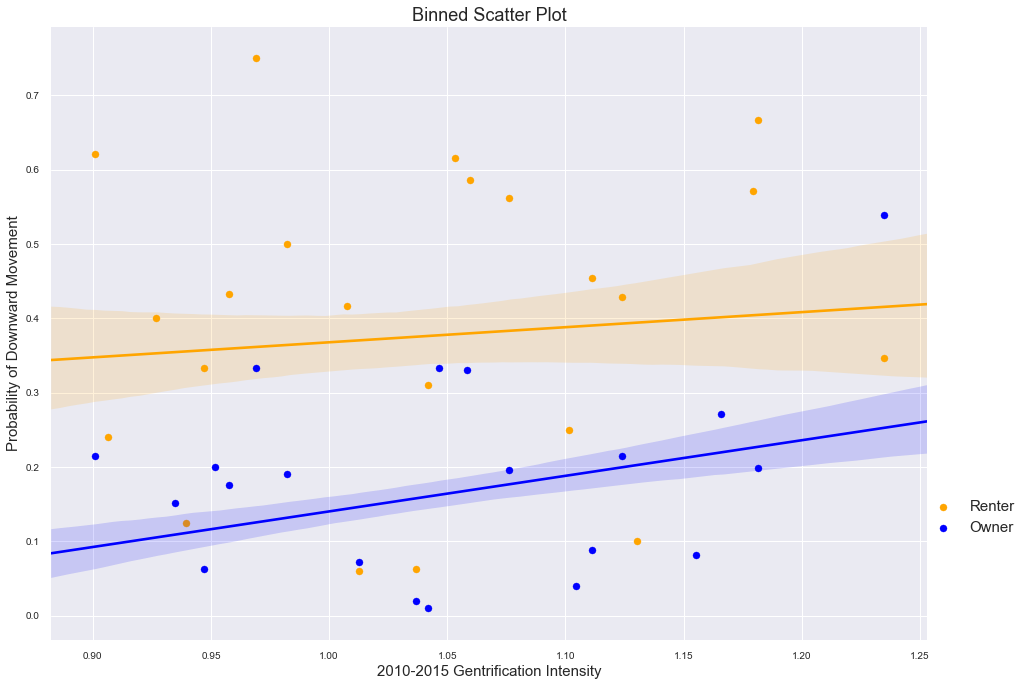

In [20]:

a4_dims = (15.7, 11.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.regplot(x = "Gentensity", y = "MHHIdown", data = mover_visual[mover_visual.OWNER_RENTER_STATUS == "Renter"]
                 , fit_reg=True, x_bins=30, x_ci = 0,color='orange', label="Renter") 
sns.regplot(x = "Gentensity", y = "MHHIdown", data = mover_visual[mover_visual.OWNER_RENTER_STATUS == "Owner"]
                 , fit_reg=True, x_bins=30, x_ci = 0,color='blue', label="Owner") 

ax.set_xlabel('2010-2015 Gentrification Intensity', fontsize=15)
ax.set_ylabel('Probability of Downward Movement', fontsize=15)
ax.set_title('Binned Scatter Plot', fontsize=18)
ax.legend(loc='center', bbox_to_anchor=(1.05, 0.2), ncol=1, fontsize = 15)

sns.despine(offset = 5, trim=True)
plt.show()

### Preliminary Finding from Graph

The binscatter plot above confirms the expectation. __First__ the positive slopes of the two linear trend lines confirm that downward probability increases with gentrification intensity. __Second__, we see that renters have higher downward probability at all levels of gentrifications. 

However, the plot is not controlling other factors related to downward movement and has displayed only a partial effect between the two variables. To systematically investigate the relationships, we need to perform __multivariate regression__ . 

## Multivariate regression 

The goal of multivariate regression is to compare households from "gentrified" neighborhoods with those from "nongentrified" neighborhoods. The first step is to prepare a table with only these two types of households. In other words, all observations from "nongentrifiable" neighborhoods are dropped, because they are distinct with the other two types of households (as shown by the summary statistics above) thus not comparable. 

In [21]:
mover_gentable = mover_gent[mover_gent.gent_class != "nongentrifiable"]

Factorize the year variable and create a continuous variable "Gentensity" that describes the gentrification intensity between 2010 to 2015. Later I will further convert the continuous variable into three categories "low", "medium" and "high" using the __quantile cut__ function in pandas. The series "Gent_Inten" is for temporary manipulation. 

In [22]:
mover_gentable['YearOnly'] = mover_gentable.YearOnly.apply(str)

mover_gentable['gent_class'] = mover_gentable['gent_class'].map(lambda x: 1 if x == 'gentrified' else 0)
mover_gentable['Gentensity'] = (mover_gentable.gent_class) * ((mover_gentable.MGR_1015 + mover_gentable.MHV_1015)/2) 

Gent_Inten = mover_gentable.Gentensity

Replace all zeroes in the series Gent_Inten with NaN. __The reason is that zero should not enter the quantile cut function.__

In [23]:
Gent_Inten = Gent_Inten.replace(0, np.NaN)

Now creates the categorical metric of gentrification based on __quartile-cutting__ the continous gentrification metric. Combine the 2nd and 3rd quartiles to be the "medium" category

In [24]:

Gent_Inten = pd.qcut(Gent_Inten, 4, labels = ["low","med","med2","high"])

Gent_Inten = Gent_Inten.replace('med2', 'med')

Gent_Inten = Gent_Inten.replace(np.NaN, "nongented")

mover_gentable['Gentensity'] = Gent_Inten


#### Perform multivariate regression. "Gentensity" is the categorical variable for gentrification intensity. 

In [26]:
lm_cnt_gent = smf.ols(formula='MHHIdown ~ +\
C(OWNER_RENTER_STATUS, Treatment(reference="Owner"))*C(Gentensity, Treatment(reference="nongented")) +\
             YearOnly + HEAD_HH_AGE_CODE + MARITAL_STATUS + HSize   + FIND_DIV_1000  + PrevLOR', data=mover_gentable).fit()


#### Use Stargazer function to display the regression results 

In [31]:
stargazer = Stargazer([lm_cnt_gent])

stargazer.covariate_order(['C(Gentensity, Treatment(reference="nongented"))[T.high]',\
'C(Gentensity, Treatment(reference="nongented"))[T.med]',\
'C(Gentensity, Treatment(reference="nongented"))[T.low]', \
'C(OWNER_RENTER_STATUS, Treatment(reference="Owner"))[T.Renter]',\
'C(OWNER_RENTER_STATUS, Treatment(reference="Owner"))[T.Renter]:C(Gentensity, \
Treatment(reference="nongented"))[T.high]',\
'C(OWNER_RENTER_STATUS, Treatment(reference="Owner"))[T.Renter]:C(Gentensity, \
Treatment(reference="nongented"))[T.med]',\
'C(OWNER_RENTER_STATUS, Treatment(reference="Owner"))[T.Renter]:C(Gentensity, \
Treatment(reference="nongented"))[T.low]'                          
                          ])

stargazer.rename_covariates({'C(Gentensity, Treatment(reference="nongented"))[T.high]': 'High Gentrification',\
'C(Gentensity, Treatment(reference="nongented"))[T.med]': 'Medium Gentrification',\
'C(Gentensity, Treatment(reference="nongented"))[T.low]': 'Low Gentrification',\
'C(OWNER_RENTER_STATUS, Treatment(reference="Owner"))[T.Renter]':'Renter (Dummy)',\
'C(OWNER_RENTER_STATUS, Treatment(reference="Owner"))[T.Renter]:C(Gentensity, \
Treatment(reference="nongented"))[T.high]':'Renter*High',\
'C(OWNER_RENTER_STATUS, Treatment(reference="Owner"))[T.Renter]:C(Gentensity, \
Treatment(reference="nongented"))[T.med]':'Renter*Medium',
'C(OWNER_RENTER_STATUS, Treatment(reference="Owner"))[T.Renter]:C(Gentensity, \
Treatment(reference="nongented"))[T.low]':'Renter*Low',
                           })

stargazer.dependent_variable_name('Dep Var: Downward Move (Dummy)')
b=stargazer.render_html()
print(display(HTML(b)))

None


### Result Interpretation

The results answer the four questions raised at the beginning of this document, and confirm the findings of the binscatter plot. __Firstly__, we see that low- to medium- levels of gentrification do not induce households to move to more disadvantaged neighborhoods, but high levels of gentrification does. Specifically, coming from a highly gentrified neighborhood raises the probability of downward movement by __8.3__ percentage points. __Secondly__, we see that renters on average are __14.4__ more percentage points more likely to experience downward movement than homeowners. __To summarize__, the finding confirm the expectation that gentrification induces downward movements, and it impacts renters more than homeowners. 